# Predict which Patients will die in 2010

### Geoffrey Lamb, Jiaqi Yu, Jialin Yu, Matthew Lipinski, Davis Nyabuti, Huiyu He, Tong Wu

#### SEIS 735-01 

#### November 29tj, 2017

## Goal

We will use the 2008 beneficiary, inpatient and outpatient data to build a model which we will use to predict which patients will die in 2010 based on the patient's 2009 data.


# Tool Selection

## GraphLab

We used `graphlab` to pre-process the data. We chose graphlab for data pre-processing because it uses out of core data structures. This allows the application to load large files without running out of memory.

## R

`R` has a rich library of predictive modeling algorithms which are well documented. It is also an easy to use language with good documentation.


## Required R packages

The following are the R packages are used in the application

In [1]:
options(java.parameters="-Xmx10g")
library(ROCR)
library (plyr)
library(rpart)
library(caret)
library(corrplot)
library(e1071)
library(data.table)
library(rpart.plot)

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: lattice
Loading required package: ggplot2
corrplot 0.84 loaded


## Load Data

In [2]:
# data
train <- fread('balanced_train.csv',sep = ",",header = T)
test <- fread('final_test.csv',sep = ",",header = T)

Read 2255098 rows and 177 (of 177) columns from 0.627 GB file in 00:00:12


In [3]:
'%!in%' <- function(x,y)!('%in%'(x,y))

predictors <- names(train) %in% c("YEAR_DESEASED")

# train[grep("CAT", names(train))]
# grep("(CAT*)|(DAYS_ADMITTED*)",names(train))
# names(train)[c(grep("(CAT*)|(DAYS_ADMITTED*)|(AGE)",names(train)))]
# numeric_cols <- names(train) %in%  names(train)[c(grep("(CAT*)|(DAYS_ADMITTED*)|(AGE)",names(train)))]

non_numeric <- names(train) %!in% names(train)[c(grep("(CAT*)|(DAYS_ADMITTED*)|(AGE)|(DESYNPUF_ID)",names(train)))]
non_numeric <- names(train)[non_numeric]
non_numeric <- unlist(non_numeric, recursive = TRUE, use.names = FALSE)
df <- as.data.frame(train)
dfTest <- as.data.frame(test)

### Decode values

- **1** denotes the presense of a condition
- **0** denotes the absense of the condition

In [4]:
# train
# Make values easy to read
df$SP_DEPRESSN <- as.character(df$SP_DEPRESSN)
df$SP_DEPRESSN[df$SP_DEPRESSN == "1"] <- 'Yes'
df$SP_DEPRESSN[df$SP_DEPRESSN == "2"] <- 'No'
df$BENE_ESRD_IND[df$BENE_ESRD_IND == "0"] <- 'No'
df$SP_ALZHDMTA[df$SP_ALZHDMTA == "1"] <- 'Yes'
df$SP_ALZHDMTA[df$SP_ALZHDMTA == "2"] <- 'No'
df$SP_CHF[df$SP_CHF == "1"] <- 'Yes'
df$SP_CHF[df$SP_CHF == "2"] <- 'No'
df$SP_CNCR[df$SP_CNCR == "1"] <- 'Yes'
df$SP_CNCR[df$SP_CNCR == "2"] <- 'No'
df$SP_COPD[df$SP_COPD == "1"] <- 'Yes'
df$SP_COPD[df$SP_COPD == "2"] <- 'No'
df$SP_DIABETES[df$SP_DIABETES == "1"] <- 'Yes'
df$SP_DIABETES[df$SP_DIABETES == "2"] <- 'No'
df$SP_ISCHMCHT[df$SP_ISCHMCHT == "1"] <- 'Yes'
df$SP_ISCHMCHT[df$SP_ISCHMCHT == "2"] <- 'No'
df$SP_OSTEOPRS[df$SP_OSTEOPRS == "1"] <- 'Yes'
df$SP_OSTEOPRS[df$SP_OSTEOPRS == "2"] <- 'No'
df$SP_CHRNKIDN[df$SP_CHRNKIDN == "1"] <- 'Yes'
df$SP_CHRNKIDN[df$SP_CHRNKIDN == "2"] <- 'No'
df$SP_RA_OA[df$SP_RA_OA == "1"] <- 'Yes'
df$SP_RA_OA[df$SP_RA_OA == "2"] <- 'No'
df$SP_STRKETIA [df$SP_STRKETIA  == "1"] <- 'Yes'
df$SP_STRKETIA [df$SP_STRKETIA  == "2"] <- 'No'

# test
# Make values easy to read
dfTest$SP_DEPRESSN <- as.character(dfTest$SP_DEPRESSN)
dfTest$SP_DEPRESSN[dfTest$SP_DEPRESSN == "1"] <- 'Yes'
dfTest$SP_DEPRESSN[dfTest$SP_DEPRESSN == "2"] <- 'No'
dfTest$BENE_ESRD_IND[dfTest$BENE_ESRD_IND == "0"] <- 'No'
dfTest$SP_ALZHDMTA[dfTest$SP_ALZHDMTA == "1"] <- 'Yes'
dfTest$SP_ALZHDMTA[dfTest$SP_ALZHDMTA == "2"] <- 'No'
dfTest$SP_CHF[dfTest$SP_CHF == "1"] <- 'Yes'
dfTest$SP_CHF[dfTest$SP_CHF == "2"] <- 'No'
dfTest$SP_CNCR[dfTest$SP_CNCR == "1"] <- 'Yes'
dfTest$SP_CNCR[dfTest$SP_CNCR == "2"] <- 'No'
dfTest$SP_COPD[dfTest$SP_COPD == "1"] <- 'Yes'
dfTest$SP_COPD[dfTest$SP_COPD == "2"] <- 'No'
dfTest$SP_DIABETES[dfTest$SP_DIABETES == "1"] <- 'Yes'
dfTest$SP_DIABETES[dfTest$SP_DIABETES == "2"] <- 'No'
dfTest$SP_ISCHMCHT[dfTest$SP_ISCHMCHT == "1"] <- 'Yes'
dfTest$SP_ISCHMCHT[dfTest$SP_ISCHMCHT == "2"] <- 'No'
dfTest$SP_OSTEOPRS[dfTest$SP_OSTEOPRS == "1"] <- 'Yes'
dfTest$SP_OSTEOPRS[dfTest$SP_OSTEOPRS == "2"] <- 'No'
dfTest$SP_CHRNKIDN[dfTest$SP_CHRNKIDN == "1"] <- 'Yes'
dfTest$SP_CHRNKIDN[dfTest$SP_CHRNKIDN == "2"] <- 'No'
dfTest$SP_RA_OA[dfTest$SP_RA_OA == "1"] <- 'Yes'
dfTest$SP_RA_OA[dfTest$SP_RA_OA == "2"] <- 'No'
dfTest$SP_STRKETIA [dfTest$SP_STRKETIA  == "1"] <- 'Yes'
dfTest$SP_STRKETIA [dfTest$SP_STRKETIA  == "2"] <- 'No'


By default the `read.csv(...)` function loaded all our predictors as numeric. However, some of these predictors are simply IDs that we need to convert to `factors`.

In [5]:
# create factors
df[non_numeric] <- lapply(df[non_numeric], factor)

drop <- c("YEAR_DESEASED","DESYNPUF_ID","BENE_DEATH_DT","BENE_BIRTH_DT")

# # Remove DESYNPUF_ID and SP_DEPRESSN from df
train.df = df[, !(names(df) %in% drop)]

dfTest[non_numeric] <- lapply(dfTest[non_numeric], factor)

drop <- c("YEAR_DESEASED","DESYNPUF_ID","BENE_DEATH_DT","BENE_BIRTH_DT")

# # Remove DESYNPUF_ID and SP_DEPRESSN from dfTest
test.df = dfTest[, !(names(dfTest) %in% drop)]

# set.seed(1011)
# # idx <- createFolds(data_y, returnTrain = TRUE)
# ctrl <- trainControl(method = "cv", savePredictions = TRUE
#                     ,summaryFunction = twoClassSummary)

In [6]:
# train.df$IS_DESEASED <- relevel(train.df$IS_DESEASED, "Y")
# test.df$IS_DESEASED <- relevel(test.df$IS_DESEASED, "Y")

Reduce test sample size

In [7]:
test.deseased <- test.df[ which(test.df$IS_DESEASED=='Y'),]
test.not.deseased <-  test.df[ which(test.df$IS_DESEASED=='N'),]
nrow(test.deseased)
nrow(test.not.deseased)


[1] 35886

[1] 2219212

There are ~ 35K deseased patients in our test data and over 2M who arent. We will reduce the number of patients who arent deseased to equal the number of patients who are deseased through random sampling

In [8]:
not.deseased.sample <- test.not.deseased[sample(nrow(test.not.deseased), 35886), ]
test.df.sample <- rbind(test.deseased, not.deseased.sample)

### Check for missing data

In [9]:
library(mice)
md.pattern(train.df)

BENE_SEX_IDENT_CD BENE_RACE_CD BENE_ESRD_IND SP_ALZHDMTA SP_CHF
13945 1                 1            1             1           1     
51681 1                 1            1             1           1     
75913 1                 1            1             1           1     
      0                 0            0             0           0     
      SP_CHRNKIDN SP_CNCR SP_COPD SP_DIABETES SP_ISCHMCHT ⋯
13945 1           1       1       1           1           ⋯
51681 1           1       1       1           1           ⋯
75913 1           1       1       1           1           ⋯
      0           0       0       0           0           ⋯
      IN_CAT4_July_December IN_CAT10_July_December IN_CAT15_March_August
13945      1                     1                      1               
51681      0                     0                      0               
75913      0                     0                      0               
      124801                124801                 124801               
      DAYS_ADMITTED_March_August IN_CAT4_May_October IN_CAT19_May_October
13945      1                          1                   1              
51681      0                          0                   0              
75913      0                          0                   0              
      124801                     124801              124801              
      IN_CAT1_May_October IN_CAT5_July_December IN_CAT5_January_June         
13945      1                   1                     1                      0
51681      0                   0                     0                     80
75913      0                   0                     0                    156
      124801              124801                124801               15753468

Assign 0 for missing numeric values

In [10]:
# library(VIM)
# mice_plot <- aggr(train.df, col=c('navyblue','yellow'),
#                     numbers=TRUE, sortVars=TRUE,
#                     labels=names(train.df), cex.axis=.7,
#                     gap=3, ylab=c("Missing data","Pattern"))
train.df[is.na(train.df)] <- 0
test.df.sample[is.na(test.df.sample)] <- 0
# summary(train.df)

### High level data analysis

We use the `str(...)` function to view the structure of the data

In [11]:
str(train.df)

'data.frame':	141539 obs. of  173 variables:
 $ BENE_SEX_IDENT_CD          : Factor w/ 2 levels "F","M": 2 2 1 1 1 1 1 1 2 1 ...
 $ BENE_RACE_CD               : Factor w/ 4 levels "Black","Hispanic",..: 3 4 4 4 4 4 4 4 4 4 ...
 $ BENE_ESRD_IND              : Factor w/ 2 levels "No","Y": 1 1 1 1 1 1 1 1 1 1 ...
 $ SP_ALZHDMTA                : Factor w/ 2 levels "No","Yes": 1 1 2 1 1 1 1 1 1 1 ...
 $ SP_CHF                     : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 2 1 1 ...
 $ SP_CHRNKIDN                : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ SP_CNCR                    : Factor w/ 2 levels "No","Yes": 1 1 1 2 1 1 1 1 1 1 ...
 $ SP_COPD                    : Factor w/ 2 levels "No","Yes": 1 1 2 1 1 1 1 1 1 1 ...
 $ SP_DIABETES                : Factor w/ 2 levels "No","Yes": 1 1 2 1 1 1 2 1 2 1 ...
 $ SP_ISCHMCHT                : Factor w/ 2 levels "No","Yes": 1 2 2 1 1 2 1 2 2 1 ...
 $ SP_OSTEOPRS                : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 2 1 2 

# Naive Bayes model

Naive Bayes assumes independence between the predictor variables

In [12]:
classifier <- naiveBayes(train.df$IS_DESEASED ~ ., data = train.df)

## Model Evaluation
We used the ROC curve to evaluate the quality of our model

### ROC Curve

To visualize the performance of our model we used the **ROC** curve. The curve is pulling away from the center to the upper left corner meaning that the model performs better than a 50/50 chance of prediction Depression. The AUC for the No class is above 0.5 while that of the Yes class is below 0.5

In [13]:
set.seed(1011)
pred <- predict(classifier, newdata= test.df.sample, type = "class")

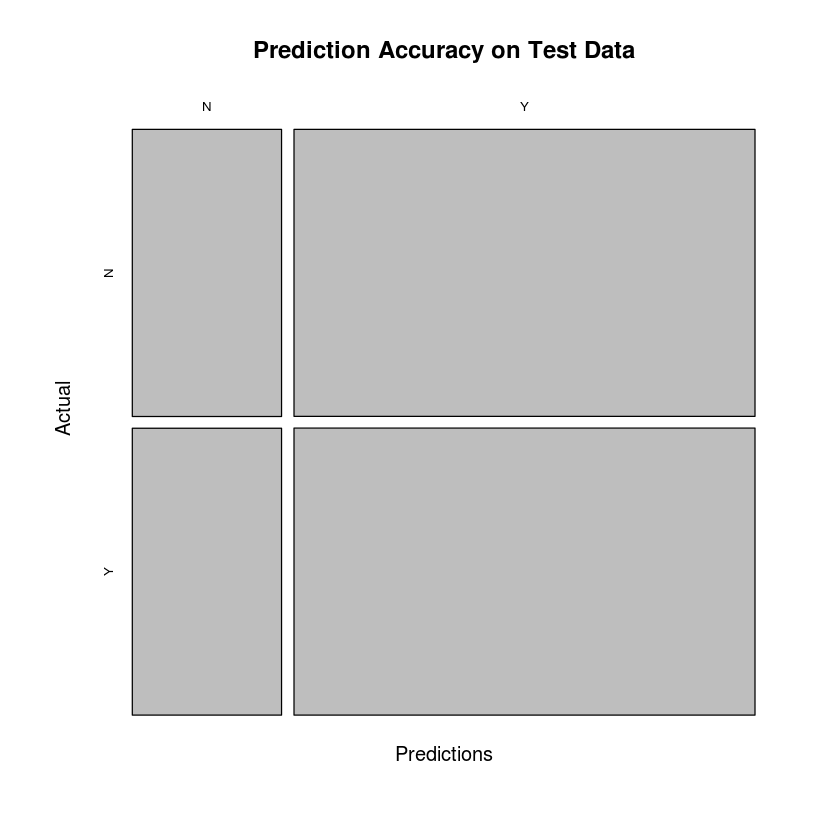

In [14]:
cfm <- confusionMatrix(test.df.sample$IS_DESEASED, pred)
pred.table <- table("Predictions"= pred,  "Actual" = test.df.sample$IS_DESEASED )
plot(pred.table, main="Prediction Accuracy on Test Data")

In [15]:
cfm
cfm$byClass

Confusion Matrix and Statistics

          Reference
Prediction     N     Y
         N  8780 27106
         Y  8773 27113
                                          
               Accuracy : 0.5001          
                 95% CI : (0.4964, 0.5038)
    No Information Rate : 0.7554          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 2e-04           
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.5002          
            Specificity : 0.5001          
         Pos Pred Value : 0.2447          
         Neg Pred Value : 0.7555          
             Prevalence : 0.2446          
         Detection Rate : 0.1223          
   Detection Prevalence : 0.5000          
      Balanced Accuracy : 0.5001          
                                          
       'Positive' Class : N               
                                          

Sensitivity          Specificity       Pos Pred Value 
           0.5001994            0.5000646            0.2446637 
      Neg Pred Value            Precision               Recall 
           0.7555314            0.2446637            0.5001994 
                  F1           Prevalence       Detection Rate 
           0.3285990            0.2445661            0.1223318 
Detection Prevalence    Balanced Accuracy 
           0.5000000            0.5001320

## Model Evaluation


The confusion matrix generated by Naive Bayes algorithm indicates the model commits a lot of error andis almost as good as a 50/50 guess

> **Naive Bayes** Confusion Matrix

```
         Reference
Prediction     N     Y
         N  7187 28699
         Y  6600 29286
  
```


### ROC Curve

In [16]:
nbprediction = predict(classifier, test.df.sample, type='raw')

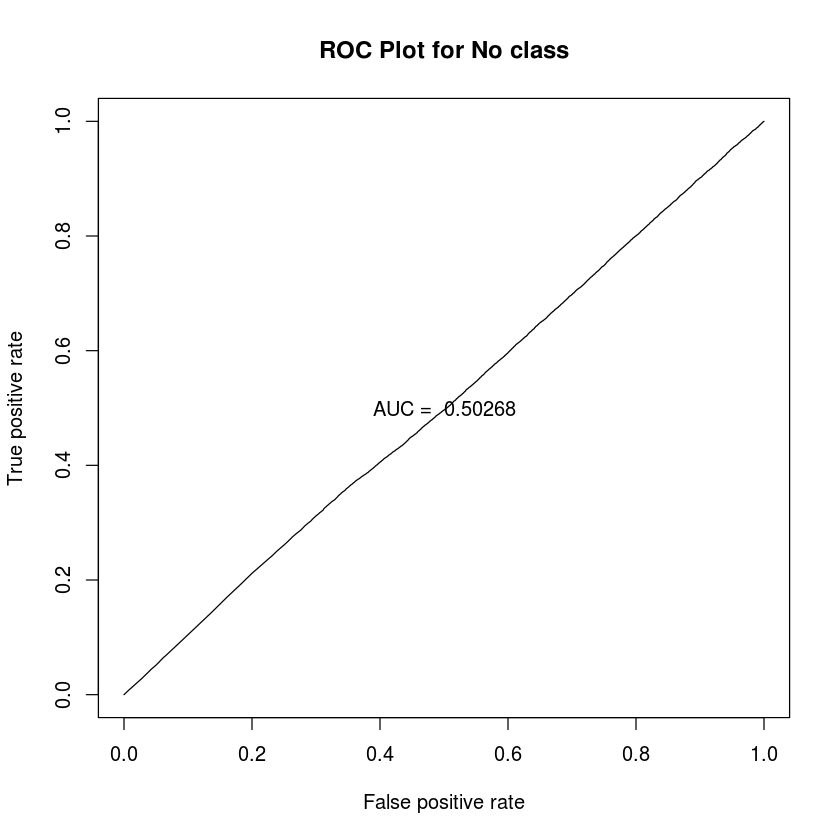

In [17]:
score = nbprediction[, 2]
actual.class = test.df.sample[,'IS_DESEASED']
pred2 = prediction(score, actual.class)
perf_AUC=performance(pred2,"auc") #Calculate the AUC value
AUC=perf_AUC@y.values[[1]]
nb.prff = performance(pred2, "tpr", "fpr")
plot(nb.prff, main="ROC Plot for No class")
text(0.5,0.5,paste("AUC = ",format(AUC, digits=5, scientific=FALSE)))

# Recursive partitioning model

Recursive partitioning (`rpart`) is a model that helps us visualize the rules used for classification. This model can perform both regression and classification. As a result, it is a good candidate to use to build a decision tree for predicting depression

In [18]:
# Tune the model
set.seed(1011)
fit <- rpart(IS_DESEASED ~ . ,method="class", data=train.df)

In [19]:
printcp(fit)


Classification tree:
rpart(formula = IS_DESEASED ~ ., data = train.df, method = "class")

Variables actually used in tree construction:
[1] AGE                     OUT_CAT19_July_December OUT_CAT8_July_December 

Root node error: 69781/141539 = 0.49302

n= 141539 

        CP nsplit rel error  xerror      xstd
1 0.108783      0   1.00000 1.00000 0.0026954
2 0.024233      1   0.89122 0.89122 0.0026758
3 0.012912      2   0.86698 0.86698 0.0026672
4 0.010000      3   0.85407 0.85407 0.0026619


## Model Evaluation

In the end the model used 4 of the most important predictors to build a decision tree. These include:
* AGE
* GENERATION
* OUT_CAT19_July_December (diseases of the respiratory system)
* OUT_CAT8_July_December (diseases of the circulatory system)

It appears that Age combined with diseases of the circulatory and respiratory system are the best predictors of whether a person will die or not

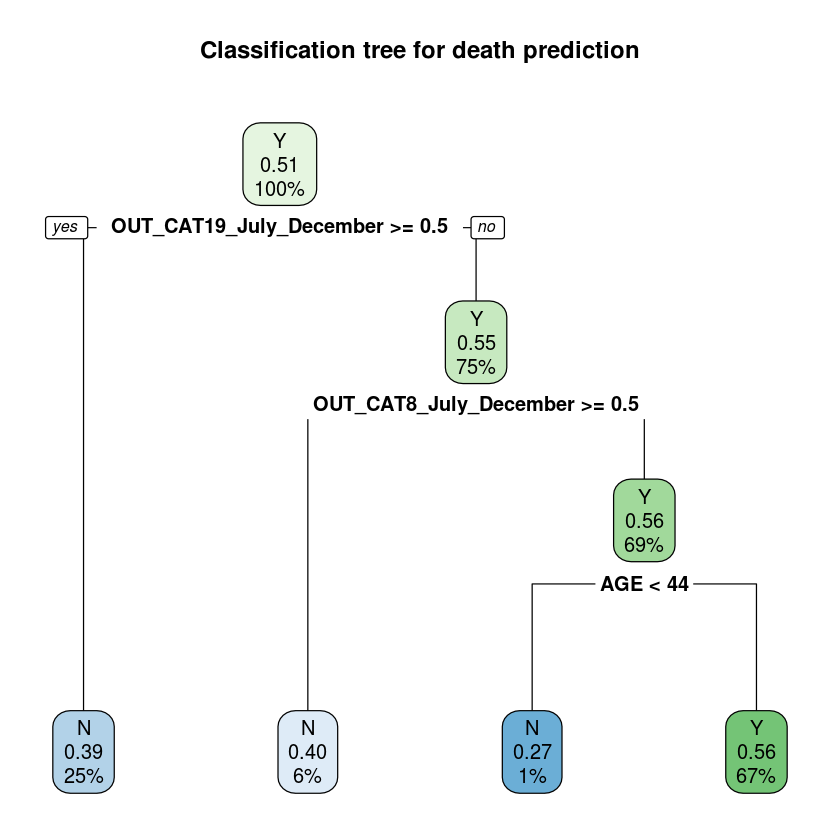

In [20]:
rpart.plot(fit, uniform=TRUE, main="Classification tree for death prediction")

Patients in the Gen X (35-50) or Greatest (Over 87) generation with external causes of injuries are at the greatest risk of death 

In [21]:
nbprediction2 = predict(fit, test.df.sample, type='prob')

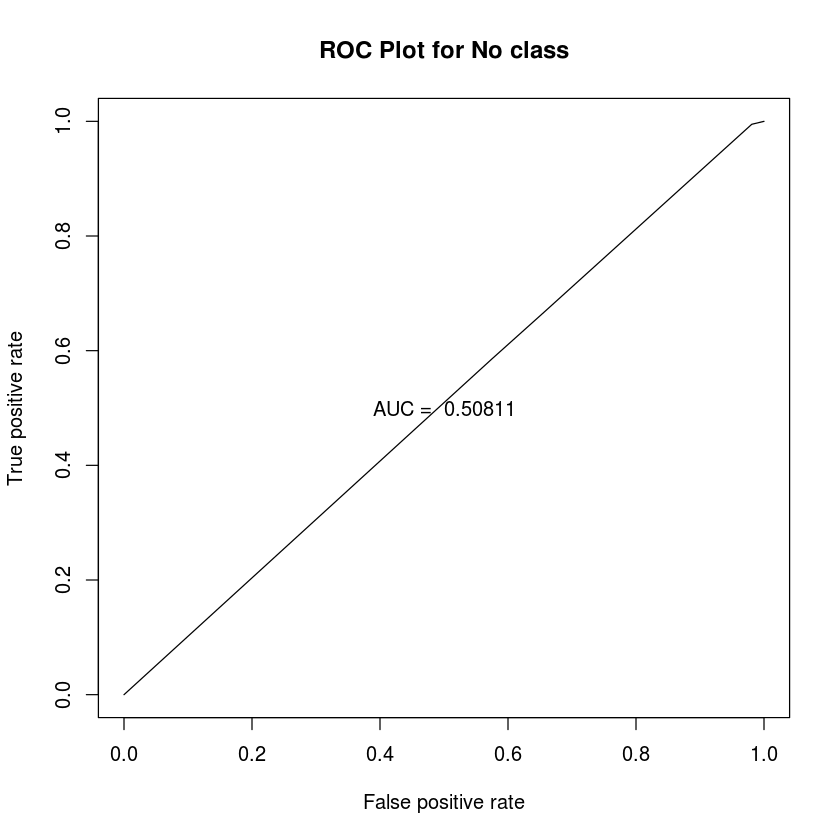

In [22]:
score = nbprediction2[, 2]
actual.class = test.df.sample[,'IS_DESEASED']
pred2 = prediction(score, actual.class)
perf_AUC=performance(pred2,"auc") #Calculate the AUC value
AUC=perf_AUC@y.values[[1]]
nb.prff = performance(pred2, "tpr", "fpr")
plot(nb.prff, main="ROC Plot for No class")
text(0.5,0.5,paste("AUC = ",format(AUC, digits=5, scientific=FALSE)))

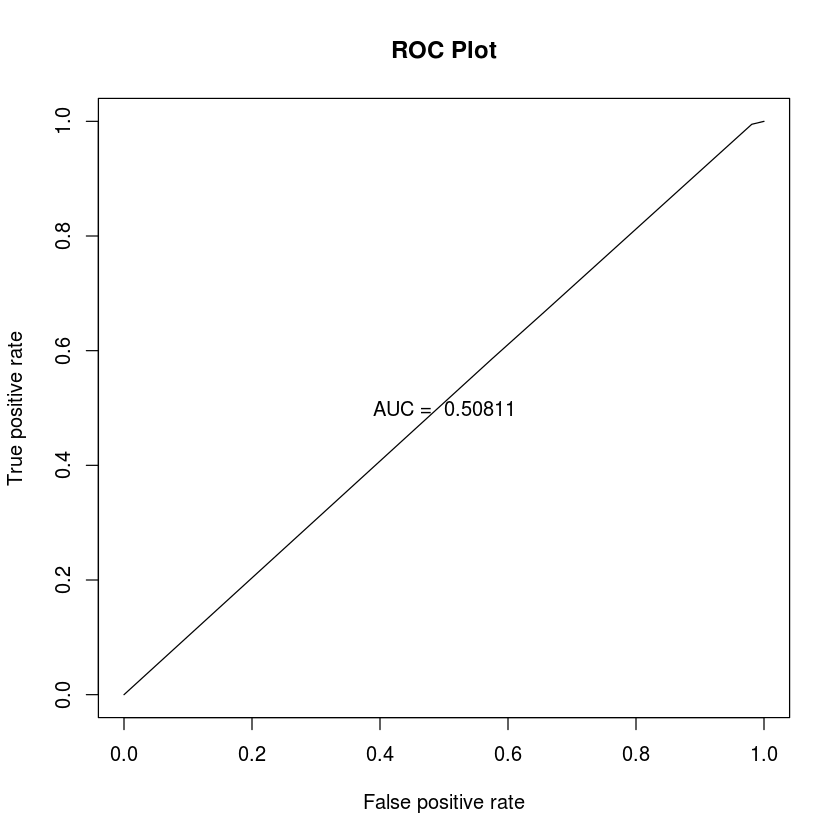

In [23]:
set.seed(1011)
library("ROCR")
pred <- prediction(predict(fit, type = "prob",newdata=test.df.sample)[, 2], test.df.sample$IS_DESEASED)
perf_AUC=performance(pred,"auc") #Calculate the AUC value
AUC=perf_AUC@y.values[[1]]
perf <- performance(pred, "tpr", "fpr")
plot(perf, main="ROC Plot")
text(0.5,0.5,paste("AUC = ",format(AUC, digits=5, scientific=FALSE)))

### Random Forest
Random Forests add randomness into the learning process. The randomness reduces the correlation
between trees. To build a Ramdom Forest model we used the `randomforest` function in the
`randomforest` package.

In [24]:
set.seed(1011)
library(randomForest)
fit <- randomForest(test.df.sample$IS_DESEASED ~ .,
                      data=test.df.sample, 
                      importance=TRUE, 
                      ntree=100)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



In [25]:
fit


Call:
 randomForest(formula = test.df.sample$IS_DESEASED ~ ., data = test.df.sample,      importance = TRUE, ntree = 100) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 13

        OOB estimate of  error rate: 48.78%
Confusion matrix:
      N     Y class.error
N 15380 20506   0.5714206
Y 14505 21381   0.4041966

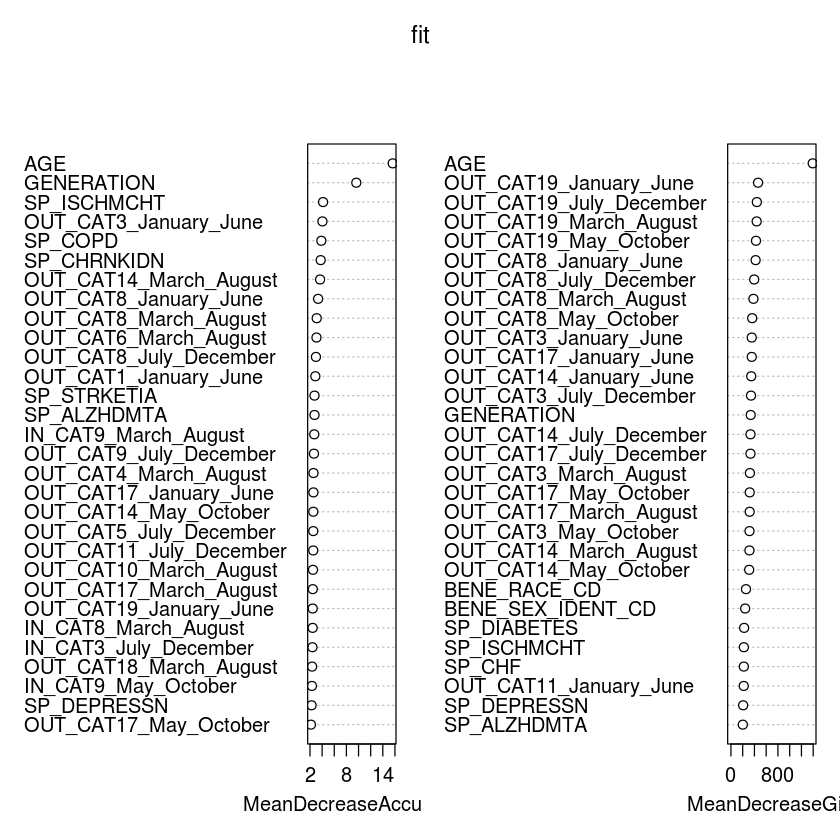

In [26]:
varImpPlot(fit)

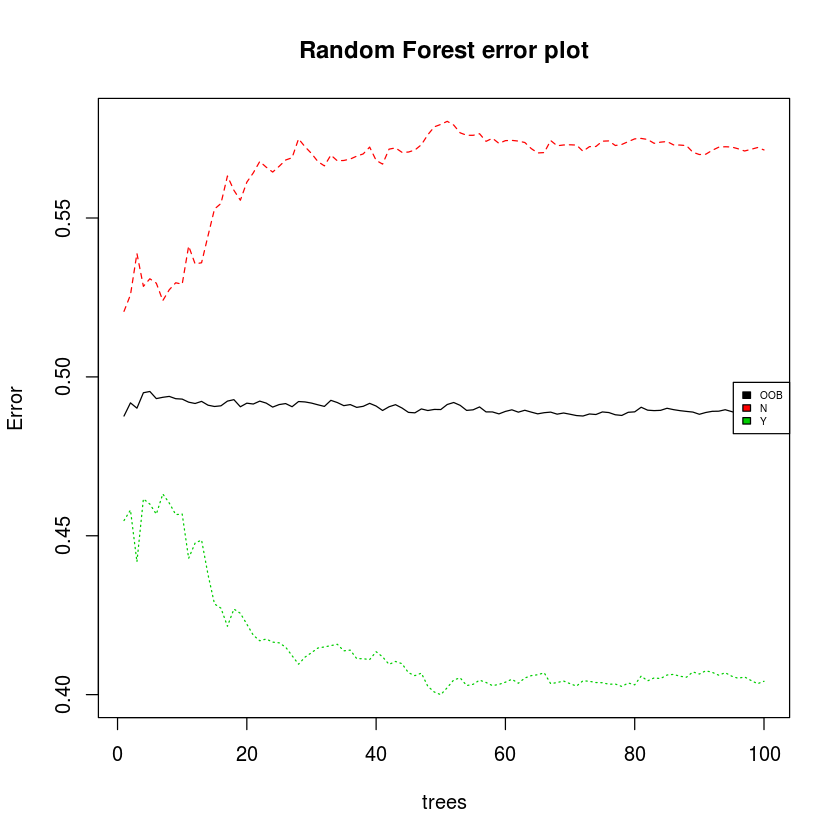

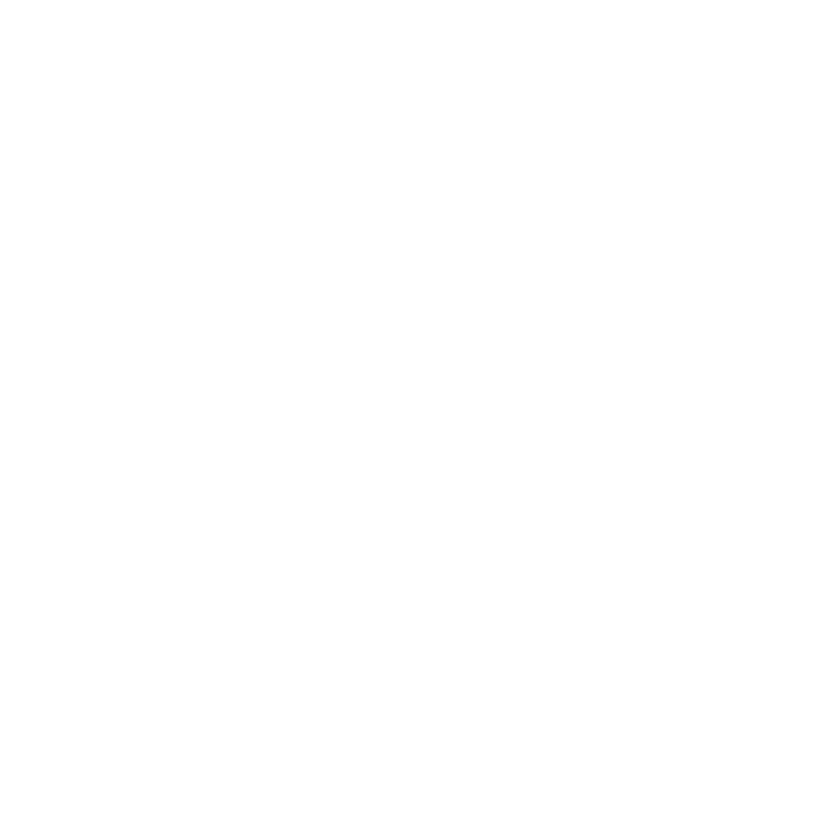

In [39]:
plot(fit,  main="Random Forest error plot")
legend("right", colnames(fit$err.rate),col=1:4,cex=0.5,fill=1:4)
par(mar=c(5,0,4,2)) #No margin on the left side
plot(c(0,1),type="n", axes=F, xlab="", ylab="")

## Conclusion

The ROC plot indicates that the model is not very good at predicting the Yes class as it commits a lot of errors

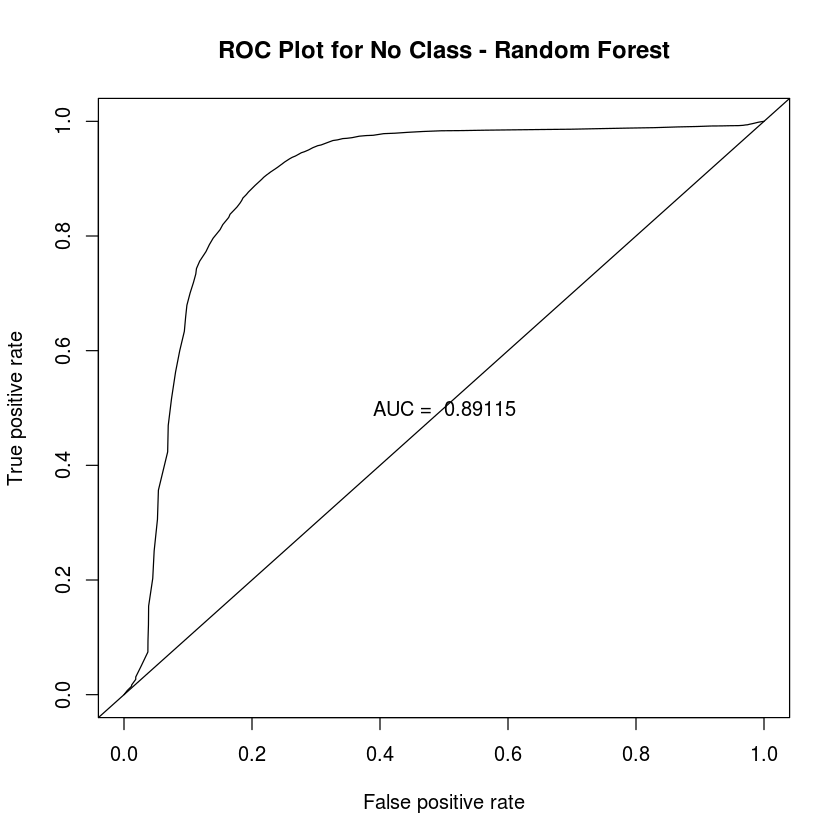

In [36]:
set.seed(1011)
library("ROCR")
pred <- prediction(predict(fit, type = "prob",newdata=test.df.sample)[, 2], test.df.sample$IS_DESEASED)
perf_AUC=performance(pred,"auc") #Calculate the AUC value
AUC=perf_AUC@y.values[[1]]
perf <- performance(pred, "tpr", "fpr")
plot(perf, main="ROC Plot for No Class - Random Forest")
abline(a=0, b= 1)
text(0.5,0.5,paste("AUC = ",format(AUC, digits=5, scientific=FALSE)))

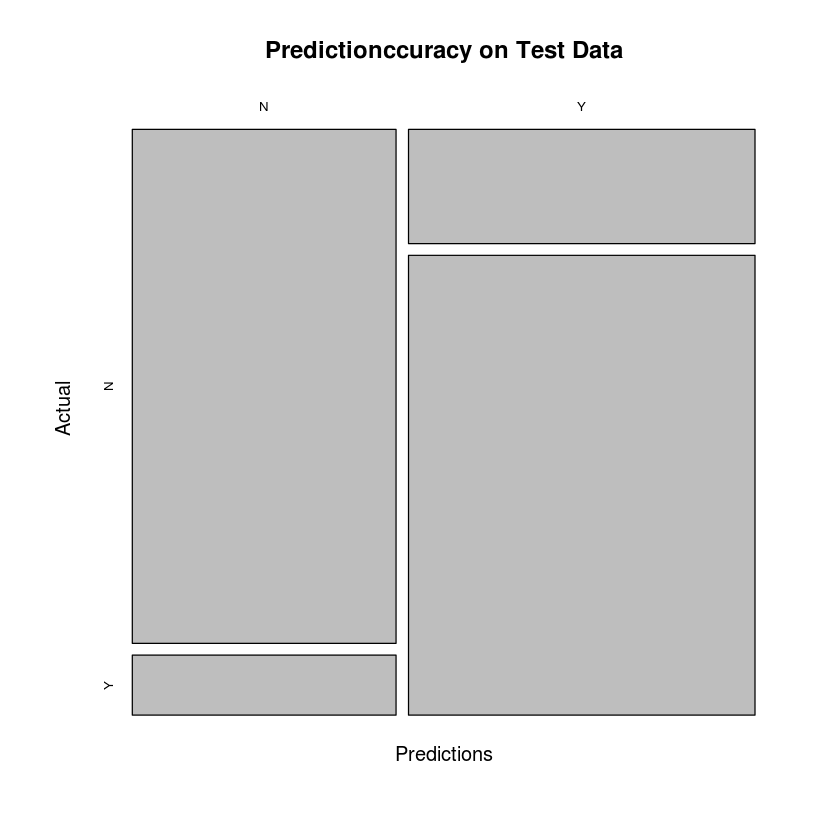

In [63]:
set.seed(1011)
pred <- predict(fit, newdata= test.df.sample, type = "class")
cfm <- confusionMatrix(test.df.sample$IS_DESEASED, pred)
pred.table <- table("Predictions"= pred,  "Actual" = test.df.sample$IS_DESEASED )
plot(pred.table, main="Predictionccuracy on Test Data")

In [64]:
cfm

Confusion Matrix and Statistics

          Reference
Prediction     N     Y
         N 27776  8110
         Y  3244 32642
                                          
               Accuracy : 0.8418          
                 95% CI : (0.8391, 0.8445)
    No Information Rate : 0.5678          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6836          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8954          
            Specificity : 0.8010          
         Pos Pred Value : 0.7740          
         Neg Pred Value : 0.9096          
             Prevalence : 0.4322          
         Detection Rate : 0.3870          
   Detection Prevalence : 0.5000          
      Balanced Accuracy : 0.8482          
                                          
       'Positive' Class : N               
                                          

In [31]:
cfm2 <- confusionMatrix(test.df.sample$IS_DESEASED, pred)
pred.table2 <- table("Predictions"= pred,  "Actual" = test.df.sample$IS_DESEASED, positive='N')
plot(pred.table2, main="Prediction Accuracy on Test Data")

ERROR: Error in table(Predictions = pred, Actual = test.df.sample$IS_DESEASED, : all arguments must have the same length


In [ ]:
cfm <- confusionMatrix(test.df.sample$IS_DESEASED, pred)
pred.table <- table("Predictions"= pred,  "Actual" = test.df.sample$IS_DESEASED )
plot(pred.table, main="Prediction Accuracy on Test Data")